In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "MNIST"
ood = "5:6:7:8:9"


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

  0%|                                                                            | 0/60000 [00:00<?, ?it/s]

 13%|███████▊                                                      | 7556/60000 [00:00<00:00, 75555.21it/s]

 25%|███████████████▎                                             | 15112/60000 [00:00<00:00, 69986.80it/s]

 38%|███████████████████████                                      | 22720/60000 [00:00<00:00, 72650.46it/s]

 51%|██████████████████████████████▉                              | 30452/60000 [00:00<00:00, 74444.35it/s]

 63%|██████████████████████████████████████▌                      | 37918/60000 [00:00<00:00, 70086.20it/s]

 76%|██████████████████████████████████████████████▏              | 45440/60000 [00:00<00:00, 71740.42it/s]

 89%|██████████████████████████████████████████████████████       | 53137/60000 [00:00<00:00, 73389.01it/s]

100%|█████████████████████████████████████████████████████████████| 60000/60000 [00:00<00:00, 72998.65it/s]

  0%|                                                                            | 0/10000 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████▍               | 7496/10000 [00:00<00:00, 74952.57it/s]

100%|█████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 73059.15it/s]

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

5:6:7:8:9 umry49p9


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

with torch.no_grad():
    trn_inp = []
    trn_e_u = []
    trn_e_v = []
    trn_rcn = []
    trn_tgt = []

    val_inp = []
    val_e_u = []
    val_e_v = []
    val_rcn = []
    val_tgt = []

    ind_inp = []
    ind_e_u = []
    ind_e_v = []
    ind_rcn = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_e_u = []
        ood_e_v = []
        ood_rcn = []
        ood_tgt = []

    rnd_inp = []
    rnd_e_u = []
    rnd_e_v = []
    rnd_rcn = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_e_u.extend(e_u.detach().cpu().numpy())
        trn_e_v.extend(e_v.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_e_u.extend(e_u.detach().cpu().numpy())
        val_e_v.extend(e_v.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_e_u.extend(e_u.detach().cpu().numpy())
        ind_e_v.extend(e_v.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_e_u.extend(e_u.detach().cpu().numpy())
            ood_e_v.extend(e_v.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_e_u.extend(e_u.detach().cpu().numpy())
        rnd_e_v.extend(e_v.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                              | 0/383 [00:00<?, ?it/s]

  0%|▏                                                                     | 1/383 [00:00<03:35,  1.78it/s]

  1%|▋                                                                     | 4/383 [00:00<00:51,  7.39it/s]

  2%|█▎                                                                    | 7/383 [00:00<00:30, 12.28it/s]

  3%|█▊                                                                   | 10/383 [00:00<00:22, 16.35it/s]

  3%|██▎                                                                  | 13/383 [00:00<00:18, 19.60it/s]

  4%|██▉                                                                  | 16/383 [00:01<00:16, 22.11it/s]

  5%|███▍                                                                 | 19/383 [00:01<00:15, 23.95it/s]

  6%|███▉                                                                 | 22/383 [00:01<00:14, 25.18it/s]

  7%|████▌                                                                | 25/383 [00:01<00:13, 26.13it/s]

  7%|█████                                                                | 28/383 [00:01<00:13, 26.86it/s]

  8%|█████▌                                                               | 31/383 [00:01<00:12, 27.38it/s]

  9%|██████▏                                                              | 34/383 [00:01<00:12, 27.74it/s]

 10%|██████▋                                                              | 37/383 [00:01<00:12, 28.01it/s]

 10%|███████▏                                                             | 40/383 [00:01<00:12, 28.18it/s]

 11%|███████▋                                                             | 43/383 [00:02<00:12, 28.32it/s]

 12%|████████▎                                                            | 46/383 [00:02<00:11, 28.42it/s]

 13%|████████▊                                                            | 49/383 [00:02<00:11, 28.48it/s]

 14%|█████████▎                                                           | 52/383 [00:02<00:11, 28.52it/s]

 14%|█████████▉                                                           | 55/383 [00:02<00:11, 28.55it/s]

 15%|██████████▍                                                          | 58/383 [00:02<00:11, 28.57it/s]

 16%|██████████▉                                                          | 61/383 [00:02<00:11, 28.46it/s]

 17%|███████████▌                                                         | 64/383 [00:02<00:11, 28.51it/s]

 17%|████████████                                                         | 67/383 [00:02<00:11, 28.55it/s]

 18%|████████████▌                                                        | 70/383 [00:02<00:10, 28.57it/s]

 19%|█████████████▏                                                       | 73/383 [00:03<00:10, 28.58it/s]

 20%|█████████████▋                                                       | 76/383 [00:03<00:10, 28.60it/s]

 21%|██████████████▏                                                      | 79/383 [00:03<00:10, 28.61it/s]

 21%|██████████████▊                                                      | 82/383 [00:03<00:10, 28.62it/s]

 22%|███████████████▎                                                     | 85/383 [00:03<00:10, 28.62it/s]

 23%|███████████████▊                                                     | 88/383 [00:03<00:10, 28.64it/s]

 24%|████████████████▍                                                    | 91/383 [00:03<00:10, 28.65it/s]

 25%|████████████████▉                                                    | 94/383 [00:03<00:10, 28.65it/s]

 25%|█████████████████▍                                                   | 97/383 [00:03<00:09, 28.65it/s]

 26%|█████████████████▊                                                  | 100/383 [00:04<00:09, 28.55it/s]

 27%|██████████████████▎                                                 | 103/383 [00:04<00:09, 28.59it/s]

 28%|██████████████████▊                                                 | 106/383 [00:04<00:09, 28.61it/s]

 28%|███████████████████▎                                                | 109/383 [00:04<00:09, 28.64it/s]

 29%|███████████████████▉                                                | 112/383 [00:04<00:09, 28.65it/s]

 30%|████████████████████▍                                               | 115/383 [00:04<00:09, 28.67it/s]

 31%|████████████████████▉                                               | 118/383 [00:04<00:09, 28.67it/s]

 32%|█████████████████████▍                                              | 121/383 [00:04<00:09, 28.65it/s]

 32%|██████████████████████                                              | 124/383 [00:04<00:09, 28.65it/s]

 33%|██████████████████████▌                                             | 127/383 [00:04<00:08, 28.65it/s]

 34%|███████████████████████                                             | 130/383 [00:05<00:08, 28.66it/s]

 35%|███████████████████████▌                                            | 133/383 [00:05<00:08, 28.64it/s]

 36%|████████████████████████▏                                           | 136/383 [00:05<00:08, 28.63it/s]

 36%|████████████████████████▋                                           | 139/383 [00:05<00:08, 28.61it/s]

 37%|█████████████████████████▏                                          | 142/383 [00:05<00:08, 28.63it/s]

 38%|█████████████████████████▋                                          | 145/383 [00:05<00:08, 28.64it/s]

 39%|██████████████████████████▎                                         | 148/383 [00:05<00:08, 28.64it/s]

 39%|██████████████████████████▊                                         | 151/383 [00:05<00:08, 28.65it/s]

 40%|███████████████████████████▎                                        | 154/383 [00:05<00:07, 28.64it/s]

 41%|███████████████████████████▊                                        | 157/383 [00:06<00:07, 28.65it/s]

 42%|████████████████████████████▍                                       | 160/383 [00:06<00:07, 28.68it/s]

 43%|████████████████████████████▉                                       | 163/383 [00:06<00:07, 28.70it/s]

 43%|█████████████████████████████▍                                      | 166/383 [00:06<00:07, 28.69it/s]

 44%|██████████████████████████████                                      | 169/383 [00:06<00:07, 28.70it/s]

 45%|██████████████████████████████▌                                     | 172/383 [00:06<00:07, 28.60it/s]

 46%|███████████████████████████████                                     | 175/383 [00:06<00:07, 28.52it/s]

 46%|███████████████████████████████▌                                    | 178/383 [00:06<00:07, 28.51it/s]

 47%|████████████████████████████████▏                                   | 181/383 [00:06<00:07, 28.51it/s]

 48%|████████████████████████████████▋                                   | 184/383 [00:06<00:07, 28.40it/s]

 49%|█████████████████████████████████▏                                  | 187/383 [00:07<00:06, 28.42it/s]

 50%|█████████████████████████████████▋                                  | 190/383 [00:07<00:06, 28.43it/s]

 50%|██████████████████████████████████▎                                 | 193/383 [00:07<00:06, 28.45it/s]

 51%|██████████████████████████████████▊                                 | 196/383 [00:07<00:06, 28.45it/s]

 52%|███████████████████████████████████▎                                | 199/383 [00:07<00:06, 28.47it/s]

 53%|███████████████████████████████████▊                                | 202/383 [00:07<00:06, 28.47it/s]

 54%|████████████████████████████████████▍                               | 205/383 [00:07<00:06, 28.47it/s]

 54%|████████████████████████████████████▉                               | 208/383 [00:07<00:06, 28.49it/s]

 55%|█████████████████████████████████████▍                              | 211/383 [00:07<00:06, 28.52it/s]

 56%|█████████████████████████████████████▉                              | 214/383 [00:08<00:05, 28.50it/s]

 57%|██████████████████████████████████████▌                             | 217/383 [00:08<00:05, 28.48it/s]

 57%|███████████████████████████████████████                             | 220/383 [00:08<00:05, 28.48it/s]

 58%|███████████████████████████████████████▌                            | 223/383 [00:08<00:05, 28.47it/s]

 59%|████████████████████████████████████████▏                           | 226/383 [00:08<00:05, 28.47it/s]

 60%|████████████████████████████████████████▋                           | 229/383 [00:08<00:05, 28.48it/s]

 61%|█████████████████████████████████████████▏                          | 232/383 [00:08<00:05, 28.48it/s]

 61%|█████████████████████████████████████████▋                          | 235/383 [00:08<00:05, 28.48it/s]

 62%|██████████████████████████████████████████▎                         | 238/383 [00:08<00:05, 28.49it/s]

 63%|██████████████████████████████████████████▊                         | 241/383 [00:08<00:04, 28.47it/s]

 64%|███████████████████████████████████████████▎                        | 244/383 [00:09<00:04, 28.47it/s]

 64%|███████████████████████████████████████████▊                        | 247/383 [00:09<00:04, 28.47it/s]

 65%|████████████████████████████████████████████▍                       | 250/383 [00:09<00:04, 28.46it/s]

 66%|████████████████████████████████████████████▉                       | 253/383 [00:09<00:04, 28.51it/s]

 67%|█████████████████████████████████████████████▍                      | 256/383 [00:09<00:04, 28.56it/s]

 68%|█████████████████████████████████████████████▉                      | 259/383 [00:09<00:04, 28.59it/s]

 68%|██████████████████████████████████████████████▌                     | 262/383 [00:09<00:04, 28.62it/s]

 69%|███████████████████████████████████████████████                     | 265/383 [00:09<00:04, 28.62it/s]

 70%|███████████████████████████████████████████████▌                    | 268/383 [00:09<00:04, 28.62it/s]

 71%|████████████████████████████████████████████████                    | 271/383 [00:10<00:03, 28.62it/s]

 72%|████████████████████████████████████████████████▋                   | 274/383 [00:10<00:03, 28.62it/s]

 72%|█████████████████████████████████████████████████▏                  | 277/383 [00:10<00:03, 28.63it/s]

 73%|█████████████████████████████████████████████████▋                  | 280/383 [00:10<00:03, 28.62it/s]

 74%|██████████████████████████████████████████████████▏                 | 283/383 [00:10<00:03, 28.61it/s]

 75%|██████████████████████████████████████████████████▊                 | 286/383 [00:10<00:03, 28.63it/s]

 75%|███████████████████████████████████████████████████▎                | 289/383 [00:10<00:03, 28.63it/s]

 76%|███████████████████████████████████████████████████▊                | 292/383 [00:10<00:03, 28.65it/s]

 77%|████████████████████████████████████████████████████▍               | 295/383 [00:10<00:03, 28.64it/s]

 78%|████████████████████████████████████████████████████▉               | 298/383 [00:10<00:02, 28.64it/s]

 79%|█████████████████████████████████████████████████████▍              | 301/383 [00:11<00:02, 28.63it/s]

 79%|█████████████████████████████████████████████████████▉              | 304/383 [00:11<00:02, 28.64it/s]

 80%|██████████████████████████████████████████████████████▌             | 307/383 [00:11<00:02, 28.64it/s]

 81%|███████████████████████████████████████████████████████             | 310/383 [00:11<00:02, 28.63it/s]

 82%|███████████████████████████████████████████████████████▌            | 313/383 [00:11<00:02, 28.61it/s]

 83%|████████████████████████████████████████████████████████            | 316/383 [00:11<00:02, 28.61it/s]

 83%|████████████████████████████████████████████████████████▋           | 319/383 [00:11<00:02, 28.42it/s]

 84%|█████████████████████████████████████████████████████████▏          | 322/383 [00:11<00:02, 28.43it/s]

 85%|█████████████████████████████████████████████████████████▋          | 325/383 [00:11<00:02, 28.41it/s]

 86%|██████████████████████████████████████████████████████████▏         | 328/383 [00:12<00:01, 28.46it/s]

 86%|██████████████████████████████████████████████████████████▊         | 331/383 [00:12<00:01, 28.51it/s]

 87%|███████████████████████████████████████████████████████████▎        | 334/383 [00:12<00:01, 28.55it/s]

 88%|███████████████████████████████████████████████████████████▊        | 337/383 [00:12<00:01, 28.59it/s]

 89%|████████████████████████████████████████████████████████████▎       | 340/383 [00:12<00:01, 28.61it/s]

 90%|████████████████████████████████████████████████████████████▉       | 343/383 [00:12<00:01, 28.62it/s]

 90%|█████████████████████████████████████████████████████████████▍      | 346/383 [00:12<00:01, 28.63it/s]

 91%|█████████████████████████████████████████████████████████████▉      | 349/383 [00:12<00:01, 28.64it/s]

 92%|██████████████████████████████████████████████████████████████▍     | 352/383 [00:12<00:01, 28.65it/s]

 93%|███████████████████████████████████████████████████████████████     | 355/383 [00:12<00:00, 28.66it/s]

 93%|███████████████████████████████████████████████████████████████▌    | 358/383 [00:13<00:00, 28.63it/s]

 94%|████████████████████████████████████████████████████████████████    | 361/383 [00:13<00:00, 28.65it/s]

 95%|████████████████████████████████████████████████████████████████▋   | 364/383 [00:13<00:00, 28.63it/s]

 96%|█████████████████████████████████████████████████████████████████▏  | 367/383 [00:13<00:00, 28.63it/s]

 97%|█████████████████████████████████████████████████████████████████▋  | 370/383 [00:13<00:00, 28.63it/s]

 97%|██████████████████████████████████████████████████████████████████▏ | 373/383 [00:13<00:00, 28.63it/s]

 98%|██████████████████████████████████████████████████████████████████▊ | 376/383 [00:13<00:00, 28.56it/s]

 99%|███████████████████████████████████████████████████████████████████▎| 379/383 [00:13<00:00, 28.62it/s]

100%|███████████████████████████████████████████████████████████████████▊| 382/383 [00:13<00:00, 28.66it/s]

100%|████████████████████████████████████████████████████████████████████| 383/383 [00:13<00:00, 27.44it/s]

train - OK


  0%|                                                                               | 0/96 [00:00<?, ?it/s]

  1%|▋                                                                      | 1/96 [00:00<00:09,  9.87it/s]

  4%|██▉                                                                    | 4/96 [00:00<00:04, 20.89it/s]

  7%|█████▏                                                                 | 7/96 [00:00<00:03, 24.39it/s]

 10%|███████▎                                                              | 10/96 [00:00<00:03, 26.02it/s]

 14%|█████████▍                                                            | 13/96 [00:00<00:03, 26.95it/s]

 17%|███████████▋                                                          | 16/96 [00:00<00:02, 27.49it/s]

 20%|█████████████▊                                                        | 19/96 [00:00<00:02, 27.82it/s]

 23%|████████████████                                                      | 22/96 [00:00<00:02, 28.05it/s]

 26%|██████████████████▏                                                   | 25/96 [00:00<00:02, 28.19it/s]

 29%|████████████████████▍                                                 | 28/96 [00:01<00:02, 28.31it/s]

 32%|██████████████████████▌                                               | 31/96 [00:01<00:02, 28.38it/s]

 35%|████████████████████████▊                                             | 34/96 [00:01<00:02, 28.43it/s]

 39%|██████████████████████████▉                                           | 37/96 [00:01<00:02, 28.47it/s]

 42%|█████████████████████████████▏                                        | 40/96 [00:01<00:01, 28.49it/s]

 45%|███████████████████████████████▎                                      | 43/96 [00:01<00:01, 28.51it/s]

 48%|█████████████████████████████████▌                                    | 46/96 [00:01<00:01, 28.52it/s]

 51%|███████████████████████████████████▋                                  | 49/96 [00:01<00:01, 28.53it/s]

 54%|█████████████████████████████████████▉                                | 52/96 [00:01<00:01, 28.54it/s]

 57%|████████████████████████████████████████                              | 55/96 [00:01<00:01, 28.56it/s]

 60%|██████████████████████████████████████████▎                           | 58/96 [00:02<00:01, 28.56it/s]

 64%|████████████████████████████████████████████▍                         | 61/96 [00:02<00:01, 28.55it/s]

 67%|██████████████████████████████████████████████▋                       | 64/96 [00:02<00:01, 28.56it/s]

 70%|████████████████████████████████████████████████▊                     | 67/96 [00:02<00:01, 28.56it/s]

 73%|███████████████████████████████████████████████████                   | 70/96 [00:02<00:00, 28.47it/s]

 76%|█████████████████████████████████████████████████████▏                | 73/96 [00:02<00:00, 28.48it/s]

 79%|███████████████████████████████████████████████████████▍              | 76/96 [00:02<00:00, 28.50it/s]

 82%|█████████████████████████████████████████████████████████▌            | 79/96 [00:02<00:00, 28.51it/s]

 85%|███████████████████████████████████████████████████████████▊          | 82/96 [00:02<00:00, 28.52it/s]

 89%|█████████████████████████████████████████████████████████████▉        | 85/96 [00:03<00:00, 28.51it/s]

 92%|████████████████████████████████████████████████████████████████▏     | 88/96 [00:03<00:00, 28.52it/s]

 95%|██████████████████████████████████████████████████████████████████▎   | 91/96 [00:03<00:00, 28.57it/s]

 98%|████████████████████████████████████████████████████████████████████▌ | 94/96 [00:03<00:00, 28.61it/s]

100%|██████████████████████████████████████████████████████████████████████| 96/96 [00:03<00:00, 27.65it/s]

val - OK


  0%|                                                                               | 0/81 [00:00<?, ?it/s]

  1%|▉                                                                      | 1/81 [00:00<00:08,  9.42it/s]

  5%|███▌                                                                   | 4/81 [00:00<00:03, 20.38it/s]

  9%|██████▏                                                                | 7/81 [00:00<00:03, 23.96it/s]

 12%|████████▋                                                             | 10/81 [00:00<00:02, 25.67it/s]

 16%|███████████▏                                                          | 13/81 [00:00<00:02, 26.61it/s]

 20%|█████████████▊                                                        | 16/81 [00:00<00:02, 27.19it/s]

 23%|████████████████▍                                                     | 19/81 [00:00<00:02, 27.55it/s]

 27%|███████████████████                                                   | 22/81 [00:00<00:02, 27.80it/s]

 31%|█████████████████████▌                                                | 25/81 [00:00<00:02, 27.95it/s]

 35%|████████████████████████▏                                             | 28/81 [00:01<00:01, 28.06it/s]

 38%|██████████████████████████▊                                           | 31/81 [00:01<00:01, 28.13it/s]

 42%|█████████████████████████████▍                                        | 34/81 [00:01<00:01, 28.20it/s]

 46%|███████████████████████████████▉                                      | 37/81 [00:01<00:01, 28.23it/s]

 49%|██████████████████████████████████▌                                   | 40/81 [00:01<00:01, 28.24it/s]

 53%|█████████████████████████████████████▏                                | 43/81 [00:01<00:01, 28.28it/s]

 57%|███████████████████████████████████████▊                              | 46/81 [00:01<00:01, 28.33it/s]

 60%|██████████████████████████████████████████▎                           | 49/81 [00:01<00:01, 28.37it/s]

 64%|████████████████████████████████████████████▉                         | 52/81 [00:01<00:01, 28.39it/s]

 68%|███████████████████████████████████████████████▌                      | 55/81 [00:02<00:00, 28.40it/s]

 72%|██████████████████████████████████████████████████                    | 58/81 [00:02<00:00, 28.39it/s]

 75%|████████████████████████████████████████████████████▋                 | 61/81 [00:02<00:00, 28.40it/s]

 79%|███████████████████████████████████████████████████████▎              | 64/81 [00:02<00:00, 28.42it/s]

 83%|█████████████████████████████████████████████████████████▉            | 67/81 [00:02<00:00, 28.43it/s]

 86%|████████████████████████████████████████████████████████████▍         | 70/81 [00:02<00:00, 28.42it/s]

 90%|███████████████████████████████████████████████████████████████       | 73/81 [00:02<00:00, 28.42it/s]

 94%|█████████████████████████████████████████████████████████████████▋    | 76/81 [00:02<00:00, 28.43it/s]

 98%|████████████████████████████████████████████████████████████████████▎ | 79/81 [00:02<00:00, 28.28it/s]

100%|██████████████████████████████████████████████████████████████████████| 81/81 [00:02<00:00, 27.30it/s]

test InD - OK


  0%|                                                                              | 0/536 [00:00<?, ?it/s]

  0%|▏                                                                     | 1/536 [00:00<00:57,  9.28it/s]

  1%|▌                                                                     | 4/536 [00:00<00:26, 20.25it/s]

  1%|▉                                                                     | 7/536 [00:00<00:22, 23.89it/s]

  2%|█▎                                                                   | 10/536 [00:00<00:20, 25.61it/s]

  2%|█▋                                                                   | 13/536 [00:00<00:19, 26.58it/s]

  3%|██                                                                   | 16/536 [00:00<00:19, 27.18it/s]

  4%|██▍                                                                  | 19/536 [00:00<00:18, 27.57it/s]

  4%|██▊                                                                  | 22/536 [00:00<00:18, 27.82it/s]

  5%|███▏                                                                 | 25/536 [00:00<00:18, 28.00it/s]

  5%|███▌                                                                 | 28/536 [00:01<00:18, 28.11it/s]

  6%|███▉                                                                 | 31/536 [00:01<00:17, 28.19it/s]

  6%|████▍                                                                | 34/536 [00:01<00:17, 28.23it/s]

  7%|████▊                                                                | 37/536 [00:01<00:17, 28.27it/s]

  7%|█████▏                                                               | 40/536 [00:01<00:17, 28.30it/s]

  8%|█████▌                                                               | 43/536 [00:01<00:17, 28.32it/s]

  9%|█████▉                                                               | 46/536 [00:01<00:17, 28.32it/s]

  9%|██████▎                                                              | 49/536 [00:01<00:17, 28.22it/s]

 10%|██████▋                                                              | 52/536 [00:01<00:17, 28.21it/s]

 10%|███████                                                              | 55/536 [00:02<00:17, 28.25it/s]

 11%|███████▍                                                             | 58/536 [00:02<00:16, 28.26it/s]

 11%|███████▊                                                             | 61/536 [00:02<00:16, 28.26it/s]

 12%|████████▏                                                            | 64/536 [00:02<00:16, 28.27it/s]

 12%|████████▋                                                            | 67/536 [00:02<00:16, 28.32it/s]

 13%|█████████                                                            | 70/536 [00:02<00:16, 28.31it/s]

 14%|█████████▍                                                           | 73/536 [00:02<00:16, 28.32it/s]

 14%|█████████▊                                                           | 76/536 [00:02<00:16, 28.32it/s]

 15%|██████████▏                                                          | 79/536 [00:02<00:16, 28.33it/s]

 15%|██████████▌                                                          | 82/536 [00:02<00:16, 28.34it/s]

 16%|██████████▉                                                          | 85/536 [00:03<00:15, 28.34it/s]

 16%|███████████▎                                                         | 88/536 [00:03<00:15, 28.34it/s]

 17%|███████████▋                                                         | 91/536 [00:03<00:15, 28.33it/s]

 18%|████████████                                                         | 94/536 [00:03<00:15, 28.33it/s]

 18%|████████████▍                                                        | 97/536 [00:03<00:15, 28.34it/s]

 19%|████████████▋                                                       | 100/536 [00:03<00:15, 28.34it/s]

 19%|█████████████                                                       | 103/536 [00:03<00:15, 28.33it/s]

 20%|█████████████▍                                                      | 106/536 [00:03<00:15, 28.31it/s]

 20%|█████████████▊                                                      | 109/536 [00:03<00:15, 28.33it/s]

 21%|██████████████▏                                                     | 112/536 [00:04<00:14, 28.34it/s]

 21%|██████████████▌                                                     | 115/536 [00:04<00:14, 28.34it/s]

 22%|██████████████▉                                                     | 118/536 [00:04<00:14, 28.33it/s]

 23%|███████████████▎                                                    | 121/536 [00:04<00:14, 28.31it/s]

 23%|███████████████▋                                                    | 124/536 [00:04<00:14, 28.32it/s]

 24%|████████████████                                                    | 127/536 [00:04<00:14, 28.33it/s]

 24%|████████████████▍                                                   | 130/536 [00:04<00:14, 28.32it/s]

 25%|████████████████▊                                                   | 133/536 [00:04<00:14, 28.33it/s]

 25%|█████████████████▎                                                  | 136/536 [00:04<00:14, 28.32it/s]

 26%|█████████████████▋                                                  | 139/536 [00:04<00:14, 28.33it/s]

 26%|██████████████████                                                  | 142/536 [00:05<00:13, 28.33it/s]

 27%|██████████████████▍                                                 | 145/536 [00:05<00:13, 28.35it/s]

 28%|██████████████████▊                                                 | 148/536 [00:05<00:13, 28.35it/s]

 28%|███████████████████▏                                                | 151/536 [00:05<00:13, 28.35it/s]

 29%|███████████████████▌                                                | 154/536 [00:05<00:13, 28.35it/s]

 29%|███████████████████▉                                                | 157/536 [00:05<00:13, 28.30it/s]

 30%|████████████████████▎                                               | 160/536 [00:05<00:13, 28.32it/s]

 30%|████████████████████▋                                               | 163/536 [00:05<00:13, 28.32it/s]

 31%|█████████████████████                                               | 166/536 [00:05<00:13, 28.32it/s]

 32%|█████████████████████▍                                              | 169/536 [00:06<00:12, 28.35it/s]

 32%|█████████████████████▊                                              | 172/536 [00:06<00:12, 28.34it/s]

 33%|██████████████████████▏                                             | 175/536 [00:06<00:12, 28.35it/s]

 33%|██████████████████████▌                                             | 178/536 [00:06<00:12, 28.36it/s]

 34%|██████████████████████▉                                             | 181/536 [00:06<00:12, 28.35it/s]

 34%|███████████████████████▎                                            | 184/536 [00:06<00:12, 28.36it/s]

 35%|███████████████████████▋                                            | 187/536 [00:06<00:12, 28.35it/s]

 35%|████████████████████████                                            | 190/536 [00:06<00:12, 28.34it/s]

 36%|████████████████████████▍                                           | 193/536 [00:06<00:12, 28.32it/s]

 37%|████████████████████████▊                                           | 196/536 [00:06<00:11, 28.34it/s]

 37%|█████████████████████████▏                                          | 199/536 [00:07<00:11, 28.33it/s]

 38%|█████████████████████████▋                                          | 202/536 [00:07<00:11, 28.34it/s]

 38%|██████████████████████████                                          | 205/536 [00:07<00:11, 28.34it/s]

 39%|██████████████████████████▍                                         | 208/536 [00:07<00:11, 28.34it/s]

 39%|██████████████████████████▊                                         | 211/536 [00:07<00:11, 28.26it/s]

 40%|███████████████████████████▏                                        | 214/536 [00:07<00:11, 28.28it/s]

 40%|███████████████████████████▌                                        | 217/536 [00:07<00:11, 28.33it/s]

 41%|███████████████████████████▉                                        | 220/536 [00:07<00:11, 28.34it/s]

 42%|████████████████████████████▎                                       | 223/536 [00:07<00:11, 28.34it/s]

 42%|████████████████████████████▋                                       | 226/536 [00:08<00:10, 28.36it/s]

 43%|█████████████████████████████                                       | 229/536 [00:08<00:10, 28.34it/s]

 43%|█████████████████████████████▍                                      | 232/536 [00:08<00:10, 28.34it/s]

 44%|█████████████████████████████▊                                      | 235/536 [00:08<00:10, 28.34it/s]

 44%|██████████████████████████████▏                                     | 238/536 [00:08<00:10, 28.33it/s]

 45%|██████████████████████████████▌                                     | 241/536 [00:08<00:10, 28.33it/s]

 46%|██████████████████████████████▉                                     | 244/536 [00:08<00:10, 28.33it/s]

 46%|███████████████████████████████▎                                    | 247/536 [00:08<00:10, 28.34it/s]

 47%|███████████████████████████████▋                                    | 250/536 [00:08<00:10, 28.34it/s]

 47%|████████████████████████████████                                    | 253/536 [00:09<00:09, 28.34it/s]

 48%|████████████████████████████████▍                                   | 256/536 [00:09<00:09, 28.34it/s]

 48%|████████████████████████████████▊                                   | 259/536 [00:09<00:09, 28.34it/s]

 49%|█████████████████████████████████▏                                  | 262/536 [00:09<00:09, 28.33it/s]

 49%|█████████████████████████████████▌                                  | 265/536 [00:09<00:09, 28.23it/s]

 50%|██████████████████████████████████                                  | 268/536 [00:09<00:09, 28.26it/s]

 51%|██████████████████████████████████▍                                 | 271/536 [00:09<00:09, 28.28it/s]

 51%|██████████████████████████████████▊                                 | 274/536 [00:09<00:09, 28.29it/s]

 52%|███████████████████████████████████▏                                | 277/536 [00:09<00:09, 28.30it/s]

 52%|███████████████████████████████████▌                                | 280/536 [00:09<00:09, 28.33it/s]

 53%|███████████████████████████████████▉                                | 283/536 [00:10<00:08, 28.32it/s]

 53%|████████████████████████████████████▎                               | 286/536 [00:10<00:08, 28.34it/s]

 54%|████████████████████████████████████▋                               | 289/536 [00:10<00:08, 28.33it/s]

 54%|█████████████████████████████████████                               | 292/536 [00:10<00:08, 28.34it/s]

 55%|█████████████████████████████████████▍                              | 295/536 [00:10<00:08, 28.34it/s]

 56%|█████████████████████████████████████▊                              | 298/536 [00:10<00:08, 28.35it/s]

 56%|██████████████████████████████████████▏                             | 301/536 [00:10<00:08, 28.35it/s]

 57%|██████████████████████████████████████▌                             | 304/536 [00:10<00:08, 28.35it/s]

 57%|██████████████████████████████████████▉                             | 307/536 [00:10<00:08, 28.35it/s]

 58%|███████████████████████████████████████▎                            | 310/536 [00:11<00:07, 28.35it/s]

 58%|███████████████████████████████████████▋                            | 313/536 [00:11<00:07, 28.34it/s]

 59%|████████████████████████████████████████                            | 316/536 [00:11<00:07, 28.35it/s]

 60%|████████████████████████████████████████▍                           | 319/536 [00:11<00:07, 28.33it/s]

 60%|████████████████████████████████████████▊                           | 322/536 [00:11<00:07, 28.34it/s]

 61%|█████████████████████████████████████████▏                          | 325/536 [00:11<00:07, 28.34it/s]

 61%|█████████████████████████████████████████▌                          | 328/536 [00:11<00:07, 28.35it/s]

 62%|█████████████████████████████████████████▉                          | 331/536 [00:11<00:07, 28.26it/s]

 62%|██████████████████████████████████████████▎                         | 334/536 [00:11<00:07, 28.27it/s]

 63%|██████████████████████████████████████████▊                         | 337/536 [00:11<00:07, 28.29it/s]

 63%|███████████████████████████████████████████▏                        | 340/536 [00:12<00:06, 28.32it/s]

 64%|███████████████████████████████████████████▌                        | 343/536 [00:12<00:06, 28.33it/s]

 65%|███████████████████████████████████████████▉                        | 346/536 [00:12<00:06, 28.34it/s]

 65%|████████████████████████████████████████████▎                       | 349/536 [00:12<00:06, 28.33it/s]

 66%|████████████████████████████████████████████▋                       | 352/536 [00:12<00:06, 28.33it/s]

 66%|█████████████████████████████████████████████                       | 355/536 [00:12<00:06, 28.33it/s]

 67%|█████████████████████████████████████████████▍                      | 358/536 [00:12<00:06, 28.33it/s]

 67%|█████████████████████████████████████████████▊                      | 361/536 [00:12<00:06, 28.36it/s]

 68%|██████████████████████████████████████████████▏                     | 364/536 [00:12<00:06, 28.36it/s]

 68%|██████████████████████████████████████████████▌                     | 367/536 [00:13<00:05, 28.37it/s]

 69%|██████████████████████████████████████████████▉                     | 370/536 [00:13<00:05, 28.38it/s]

 70%|███████████████████████████████████████████████▎                    | 373/536 [00:13<00:05, 28.37it/s]

 70%|███████████████████████████████████████████████▋                    | 376/536 [00:13<00:05, 28.36it/s]

 71%|████████████████████████████████████████████████                    | 379/536 [00:13<00:05, 28.35it/s]

 71%|████████████████████████████████████████████████▍                   | 382/536 [00:13<00:05, 28.34it/s]

 72%|████████████████████████████████████████████████▊                   | 385/536 [00:13<00:05, 28.34it/s]

 72%|█████████████████████████████████████████████████▏                  | 388/536 [00:13<00:05, 28.34it/s]

 73%|█████████████████████████████████████████████████▌                  | 391/536 [00:13<00:05, 28.34it/s]

 74%|█████████████████████████████████████████████████▉                  | 394/536 [00:13<00:05, 28.36it/s]

 74%|██████████████████████████████████████████████████▎                 | 397/536 [00:14<00:04, 28.32it/s]

 75%|██████████████████████████████████████████████████▋                 | 400/536 [00:14<00:04, 28.31it/s]

 75%|███████████████████████████████████████████████████▏                | 403/536 [00:14<00:04, 28.31it/s]

 76%|███████████████████████████████████████████████████▌                | 406/536 [00:14<00:04, 28.33it/s]

 76%|███████████████████████████████████████████████████▉                | 409/536 [00:14<00:04, 28.34it/s]

 77%|████████████████████████████████████████████████████▎               | 412/536 [00:14<00:04, 28.36it/s]

 77%|████████████████████████████████████████████████████▋               | 415/536 [00:14<00:04, 28.37it/s]

 78%|█████████████████████████████████████████████████████               | 418/536 [00:14<00:04, 28.37it/s]

 79%|█████████████████████████████████████████████████████▍              | 421/536 [00:14<00:04, 28.38it/s]

 79%|█████████████████████████████████████████████████████▊              | 424/536 [00:15<00:03, 28.39it/s]

 80%|██████████████████████████████████████████████████████▏             | 427/536 [00:15<00:03, 28.38it/s]

 80%|██████████████████████████████████████████████████████▌             | 430/536 [00:15<00:03, 28.37it/s]

 81%|██████████████████████████████████████████████████████▉             | 433/536 [00:15<00:03, 28.36it/s]

 81%|███████████████████████████████████████████████████████▎            | 436/536 [00:15<00:03, 28.36it/s]

 82%|███████████████████████████████████████████████████████▋            | 439/536 [00:15<00:03, 28.34it/s]

 82%|████████████████████████████████████████████████████████            | 442/536 [00:15<00:03, 28.35it/s]

 83%|████████████████████████████████████████████████████████▍           | 445/536 [00:15<00:03, 28.34it/s]

 84%|████████████████████████████████████████████████████████▊           | 448/536 [00:15<00:03, 28.34it/s]

 84%|█████████████████████████████████████████████████████████▏          | 451/536 [00:15<00:03, 28.33it/s]

 85%|█████████████████████████████████████████████████████████▌          | 454/536 [00:16<00:02, 28.34it/s]

 85%|█████████████████████████████████████████████████████████▉          | 457/536 [00:16<00:02, 28.39it/s]

 86%|██████████████████████████████████████████████████████████▎         | 460/536 [00:16<00:02, 28.38it/s]

 86%|██████████████████████████████████████████████████████████▋         | 463/536 [00:16<00:02, 28.39it/s]

 87%|███████████████████████████████████████████████████████████         | 466/536 [00:16<00:02, 28.41it/s]

 88%|███████████████████████████████████████████████████████████▌        | 469/536 [00:16<00:02, 28.40it/s]

 88%|███████████████████████████████████████████████████████████▉        | 472/536 [00:16<00:02, 28.40it/s]

 89%|████████████████████████████████████████████████████████████▎       | 475/536 [00:16<00:02, 28.39it/s]

 89%|████████████████████████████████████████████████████████████▋       | 478/536 [00:16<00:02, 28.39it/s]

 90%|█████████████████████████████████████████████████████████████       | 481/536 [00:17<00:01, 28.41it/s]

 90%|█████████████████████████████████████████████████████████████▍      | 484/536 [00:17<00:01, 28.40it/s]

 91%|█████████████████████████████████████████████████████████████▊      | 487/536 [00:17<00:01, 28.42it/s]

 91%|██████████████████████████████████████████████████████████████▏     | 490/536 [00:17<00:01, 28.41it/s]

 92%|██████████████████████████████████████████████████████████████▌     | 493/536 [00:17<00:01, 28.41it/s]

 93%|██████████████████████████████████████████████████████████████▉     | 496/536 [00:17<00:01, 28.42it/s]

 93%|███████████████████████████████████████████████████████████████▎    | 499/536 [00:17<00:01, 28.41it/s]

 94%|███████████████████████████████████████████████████████████████▋    | 502/536 [00:17<00:01, 28.43it/s]

 94%|████████████████████████████████████████████████████████████████    | 505/536 [00:17<00:01, 28.43it/s]

 95%|████████████████████████████████████████████████████████████████▍   | 508/536 [00:17<00:00, 28.46it/s]

 95%|████████████████████████████████████████████████████████████████▊   | 511/536 [00:18<00:00, 28.42it/s]

 96%|█████████████████████████████████████████████████████████████████▏  | 514/536 [00:18<00:00, 28.41it/s]

 96%|█████████████████████████████████████████████████████████████████▌  | 517/536 [00:18<00:00, 28.40it/s]

 97%|█████████████████████████████████████████████████████████████████▉  | 520/536 [00:18<00:00, 28.40it/s]

 98%|██████████████████████████████████████████████████████████████████▎ | 523/536 [00:18<00:00, 28.40it/s]

 98%|██████████████████████████████████████████████████████████████████▋ | 526/536 [00:18<00:00, 28.40it/s]

 99%|███████████████████████████████████████████████████████████████████ | 529/536 [00:18<00:00, 28.40it/s]

 99%|███████████████████████████████████████████████████████████████████▍| 532/536 [00:18<00:00, 28.41it/s]

100%|███████████████████████████████████████████████████████████████████▊| 535/536 [00:18<00:00, 28.41it/s]

100%|████████████████████████████████████████████████████████████████████| 536/536 [00:19<00:00, 28.17it/s]

test OoD - OK


  0%|                                                                              | 0/100 [00:00<?, ?it/s]

  4%|██▊                                                                   | 4/100 [00:00<00:03, 31.79it/s]

  8%|█████▌                                                                | 8/100 [00:00<00:02, 31.82it/s]

 12%|████████▎                                                            | 12/100 [00:00<00:02, 31.84it/s]

 16%|███████████                                                          | 16/100 [00:00<00:02, 31.85it/s]

 20%|█████████████▊                                                       | 20/100 [00:00<00:02, 31.86it/s]

 24%|████████████████▌                                                    | 24/100 [00:00<00:02, 31.86it/s]

 28%|███████████████████▎                                                 | 28/100 [00:00<00:02, 31.85it/s]

 32%|██████████████████████                                               | 32/100 [00:01<00:02, 31.85it/s]

 36%|████████████████████████▊                                            | 36/100 [00:01<00:02, 31.87it/s]

 40%|███████████████████████████▌                                         | 40/100 [00:01<00:01, 31.87it/s]

 44%|██████████████████████████████▎                                      | 44/100 [00:01<00:01, 31.88it/s]

 48%|█████████████████████████████████                                    | 48/100 [00:01<00:01, 31.88it/s]

 52%|███████████████████████████████████▉                                 | 52/100 [00:01<00:01, 31.87it/s]

 56%|██████████████████████████████████████▋                              | 56/100 [00:01<00:01, 31.85it/s]

 60%|█████████████████████████████████████████▍                           | 60/100 [00:01<00:01, 31.71it/s]

 64%|████████████████████████████████████████████▏                        | 64/100 [00:02<00:01, 31.75it/s]

 68%|██████████████████████████████████████████████▉                      | 68/100 [00:02<00:01, 31.78it/s]

 72%|█████████████████████████████████████████████████▋                   | 72/100 [00:02<00:00, 31.80it/s]

 76%|████████████████████████████████████████████████████▍                | 76/100 [00:02<00:00, 31.83it/s]

 80%|███████████████████████████████████████████████████████▏             | 80/100 [00:02<00:00, 31.82it/s]

 84%|█████████████████████████████████████████████████████████▉           | 84/100 [00:02<00:00, 31.84it/s]

 88%|████████████████████████████████████████████████████████████▋        | 88/100 [00:02<00:00, 31.86it/s]

 92%|███████████████████████████████████████████████████████████████▍     | 92/100 [00:02<00:00, 31.88it/s]

 96%|██████████████████████████████████████████████████████████████████▏  | 96/100 [00:03<00:00, 31.88it/s]

100%|████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.90it/s]

100%|████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.84it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(24476, 1, 32, 32) (24476, 256) (24476, 768) (24476, 1, 32, 32) (24476,)
(6120, 1, 32, 32) (6120, 256) (6120, 768) (6120, 1, 32, 32) (6120,)
(5139, 1, 32, 32) (5139, 256) (5139, 768) (5139, 1, 32, 32) (5139,)
(34265, 1, 32, 32) (34265, 256) (34265, 768) (34265, 1, 32, 32) (34265,)
(6400, 1, 32, 32) (6400, 256) (6400, 768) (6400, 1, 32, 32)


In [12]:
from tsnecuda import TSNE

n = ind_inp.shape[0]
if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_u2d = tsne.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_v2d = tsne.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

(5139, 2) (34265, 2)


(5139, 2) (34265, 2)


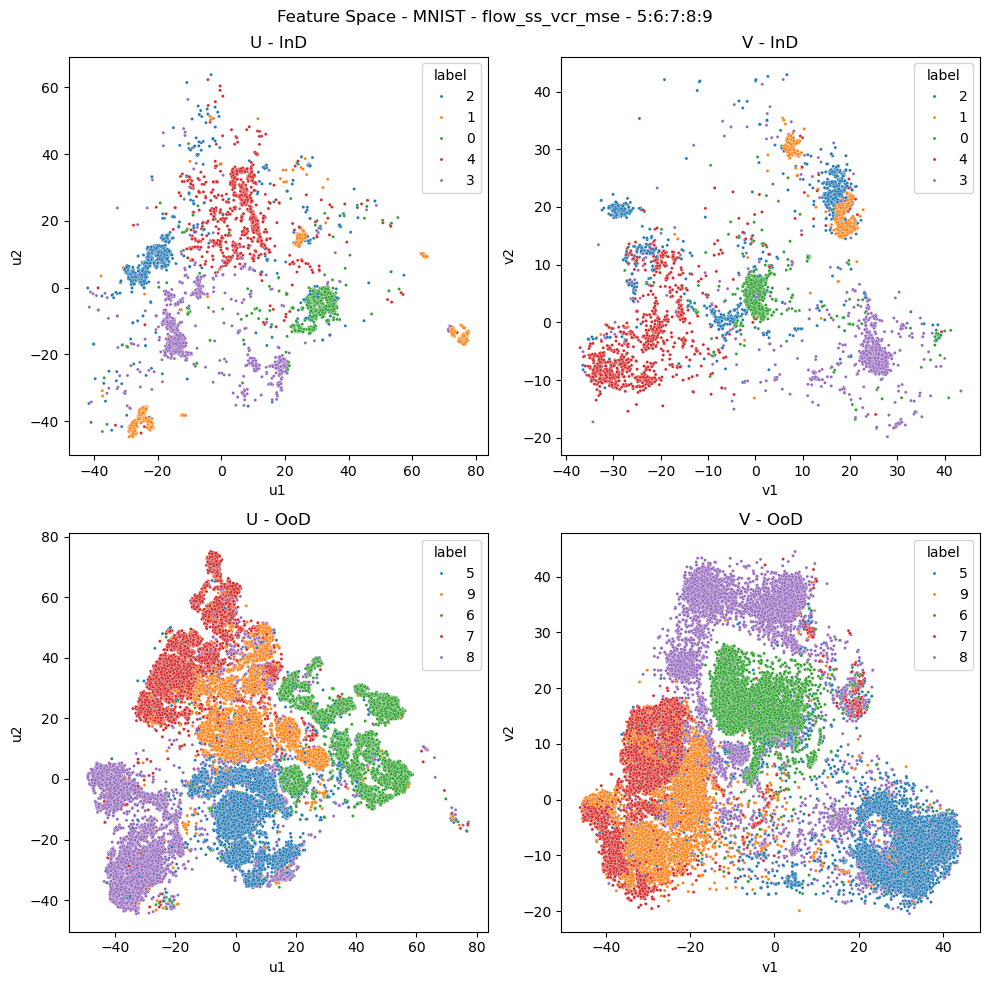

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
df_emb2d = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)
plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:01<00:03,  1.08s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:02<00:02,  1.20s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:03<00:01,  1.20s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.28s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.24s/it]

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:02<00:07,  2.59s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:05<00:05,  2.62s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:07<00:02,  2.66s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.75s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.71s/it]

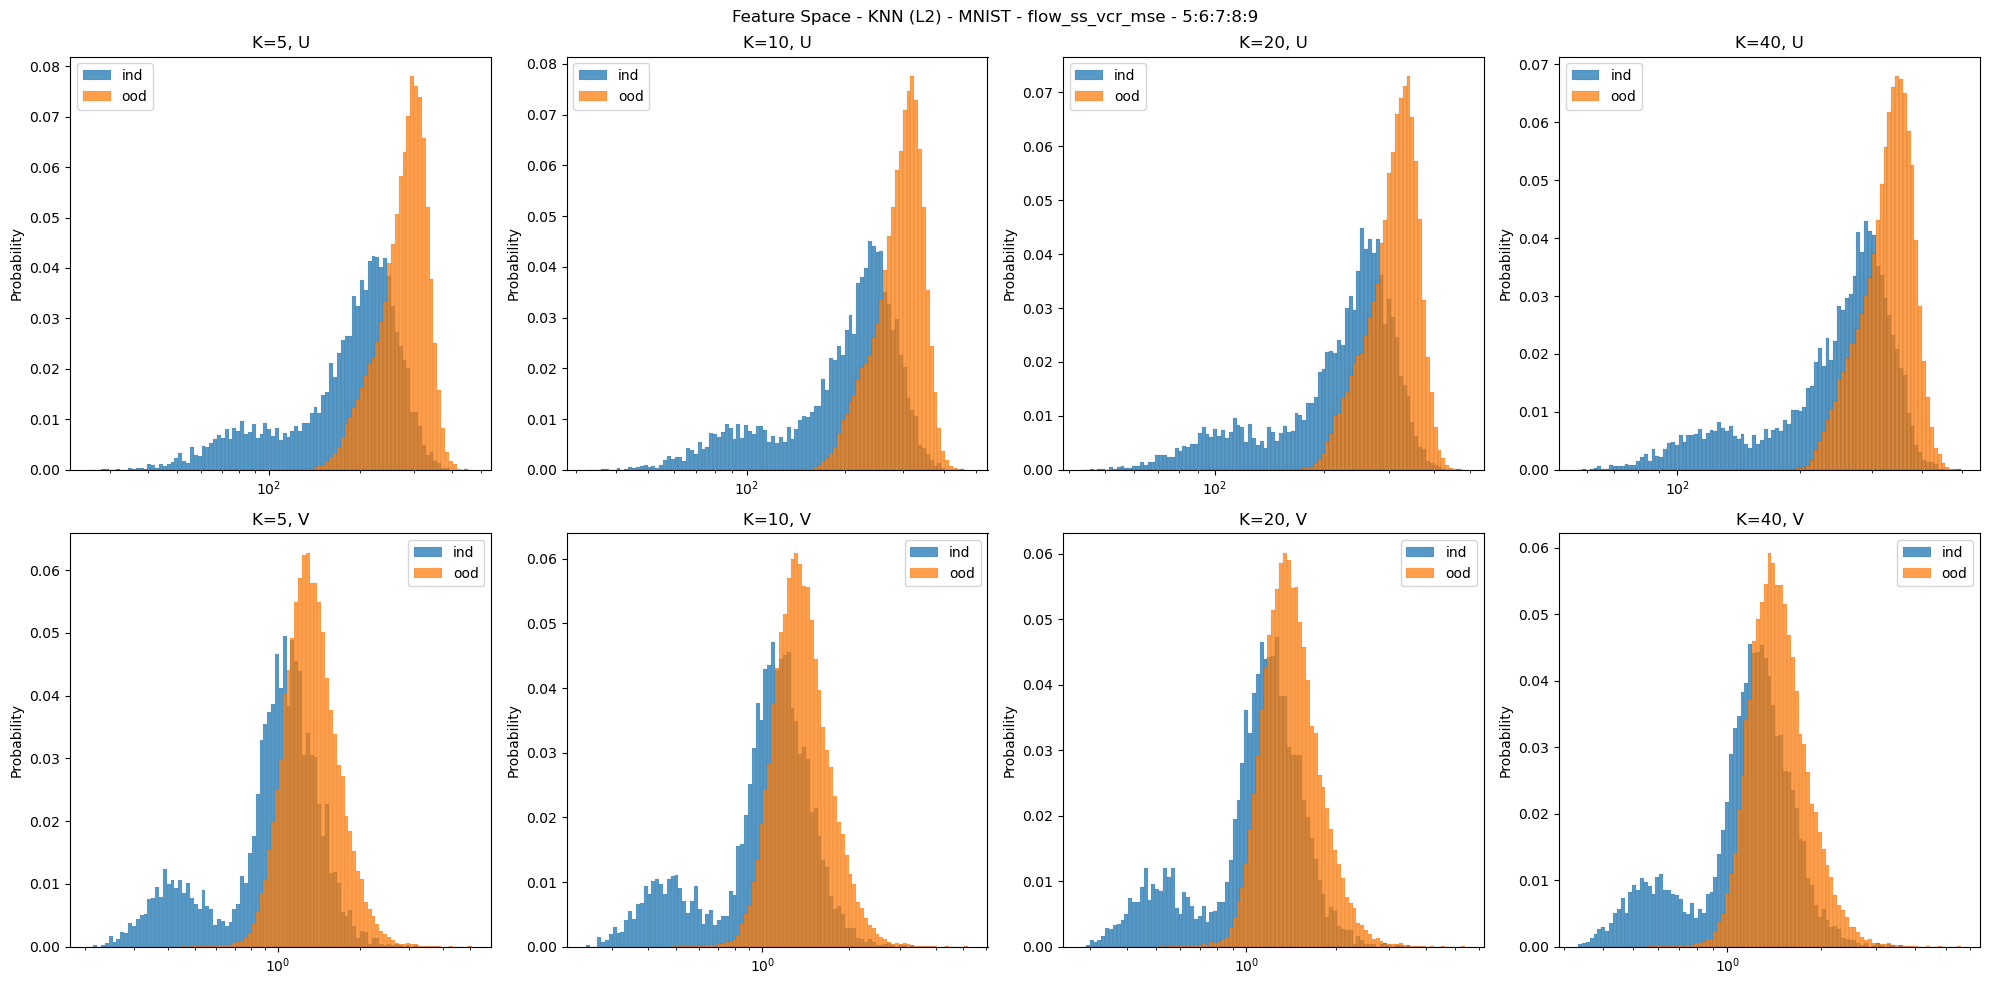

In [14]:
import faiss

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

index = faiss.IndexFlatL2(ind_e_u.shape[-1])
index.add(val_e_u)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_u, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index = faiss.IndexFlatL2(ind_e_v.shape[-1])
index.add(val_e_v)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_v, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:01<00:03,  1.04s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:02<00:02,  1.07s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:03<00:01,  1.12s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.21s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.17s/it]

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:02<00:07,  2.55s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:05<00:05,  2.57s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:07<00:02,  2.62s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.71s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.67s/it]

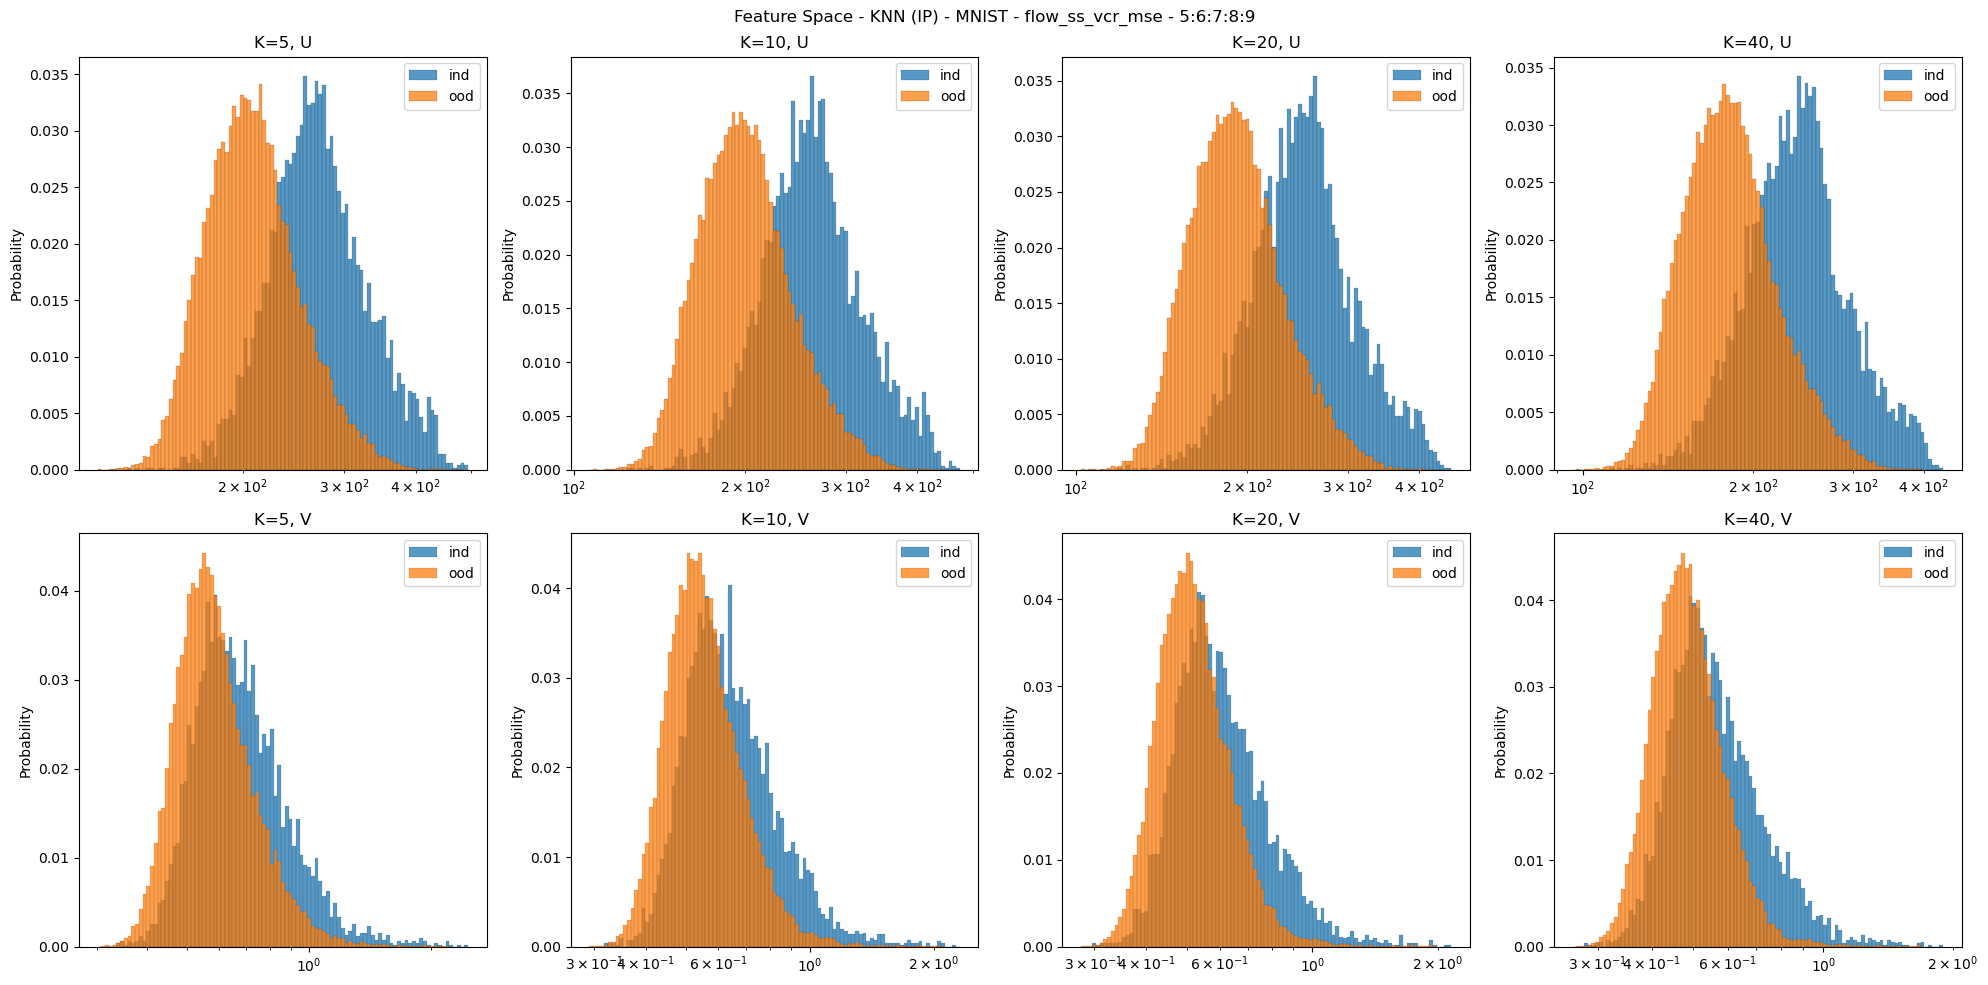

In [15]:
import faiss

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

index = faiss.IndexFlatIP(ind_e_u.shape[-1])
index.add(val_e_u)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_u, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index = faiss.IndexFlatIP(ind_e_v.shape[-1])
index.add(val_e_v)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_v, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

In [16]:
from scipy.linalg import norm

trn_n_u = norm(trn_e_u, axis=-1)
trn_n_v = norm(trn_e_v, axis=-1)
val_n_u = norm(val_e_u, axis=-1)
val_n_v = norm(val_e_v, axis=-1)
ind_n_u = norm(ind_e_u, axis=-1)
ind_n_v = norm(ind_e_v, axis=-1)
if ood_str:
    ood_n_u = norm(ood_e_u, axis=-1)
    ood_n_v = norm(ood_e_v, axis=-1)
rnd_n_u = norm(rnd_e_u, axis=-1)
rnd_n_v = norm(rnd_e_v, axis=-1)

print(trn_n_u.mean(), trn_n_u.std(), trn_n_v.mean(), trn_n_v.std())
print(val_n_u.mean(), val_n_u.std(), val_n_v.mean(), val_n_v.std())
print(ind_n_u.mean(), ind_n_u.std(), ind_n_v.mean(), ind_n_v.std())
if ood_str:
    print(ood_n_u.mean(), ood_n_u.std(), ood_n_v.mean(), ood_n_v.std())
print(rnd_n_u.mean(), rnd_n_u.std(), rnd_n_v.mean(), rnd_n_v.std())

18.974464 1.675063 1.0916302 0.16049701
18.954039 1.6441207 1.0941634 0.16495934
19.015255 1.7016404 1.085783 0.16013539
18.475555 1.3167961 1.14781 0.14863475
33.79461 2.514008 24.835228 0.7264701


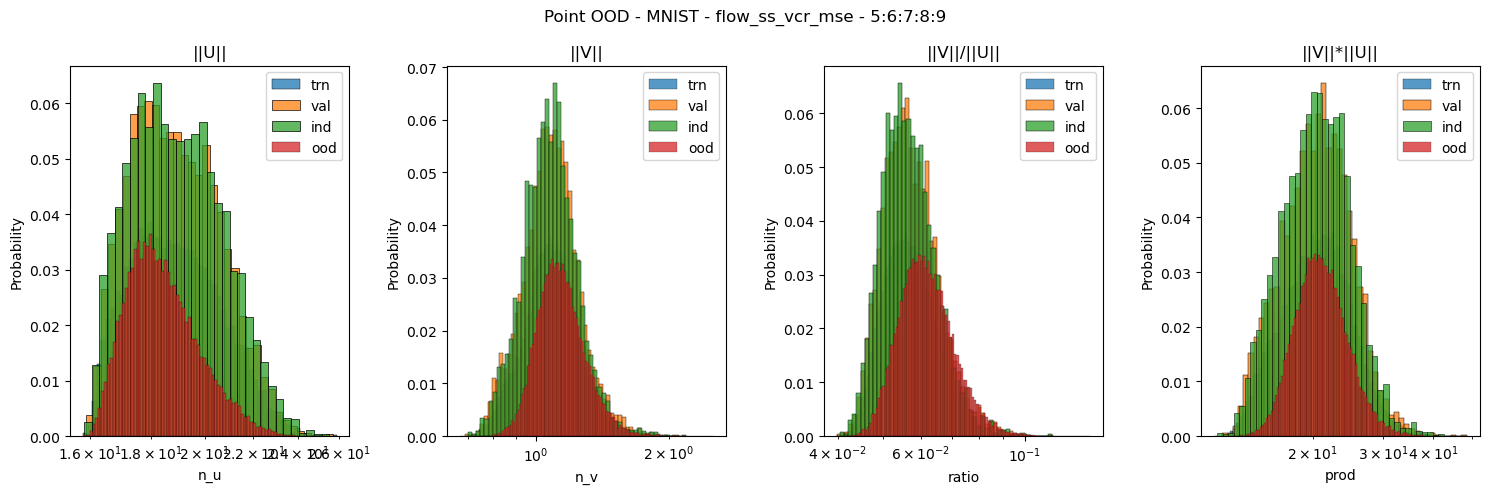

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))
df_rnd = pd.DataFrame(dict(n_u=rnd_n_u, n_v=rnd_n_v, ratio=rnd_n_v/rnd_n_u, prod=rnd_n_v*rnd_n_u))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    # sns.histplot(data=df_rnd, x=prop, log_scale=True, fill=True, label='rnd', stat='probability', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [18]:
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


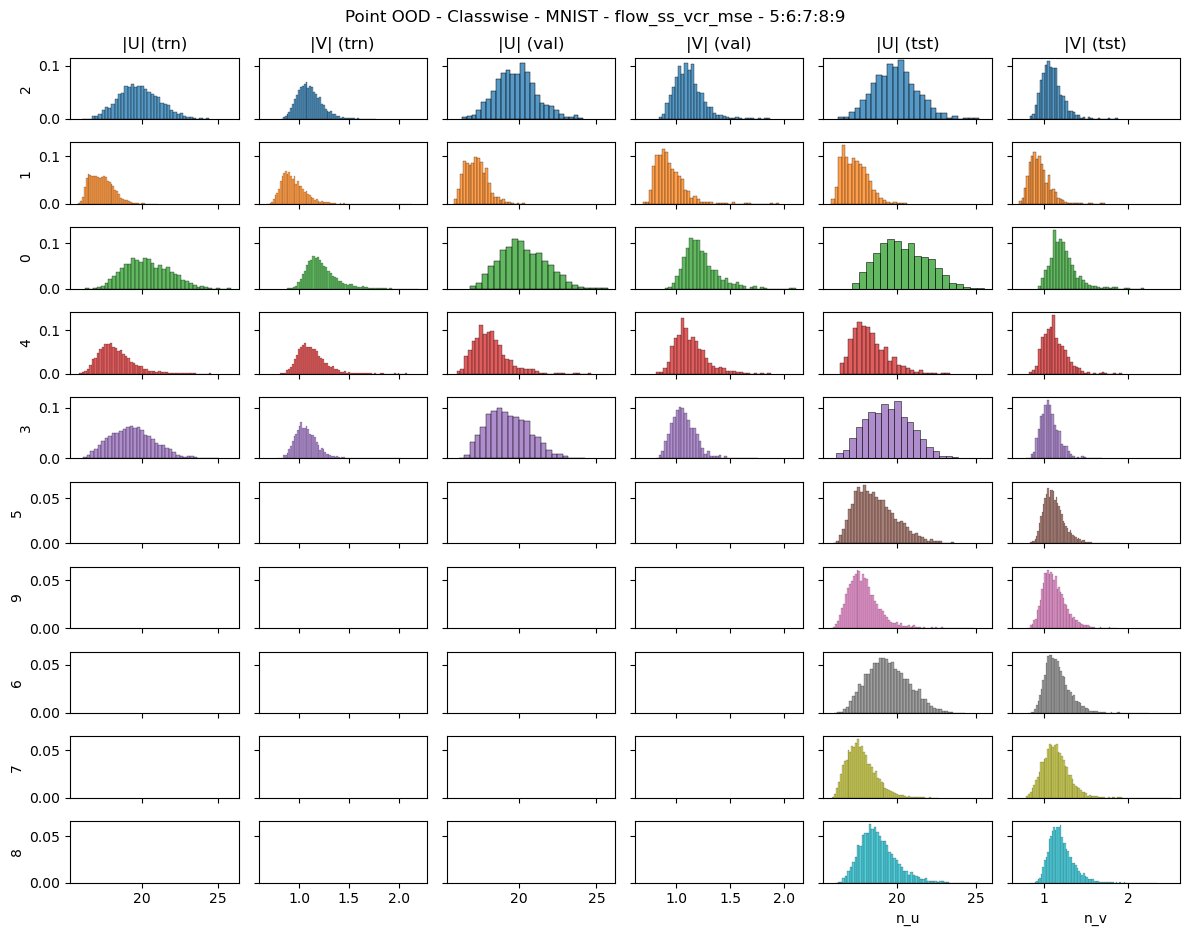

In [19]:
# pointwise
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

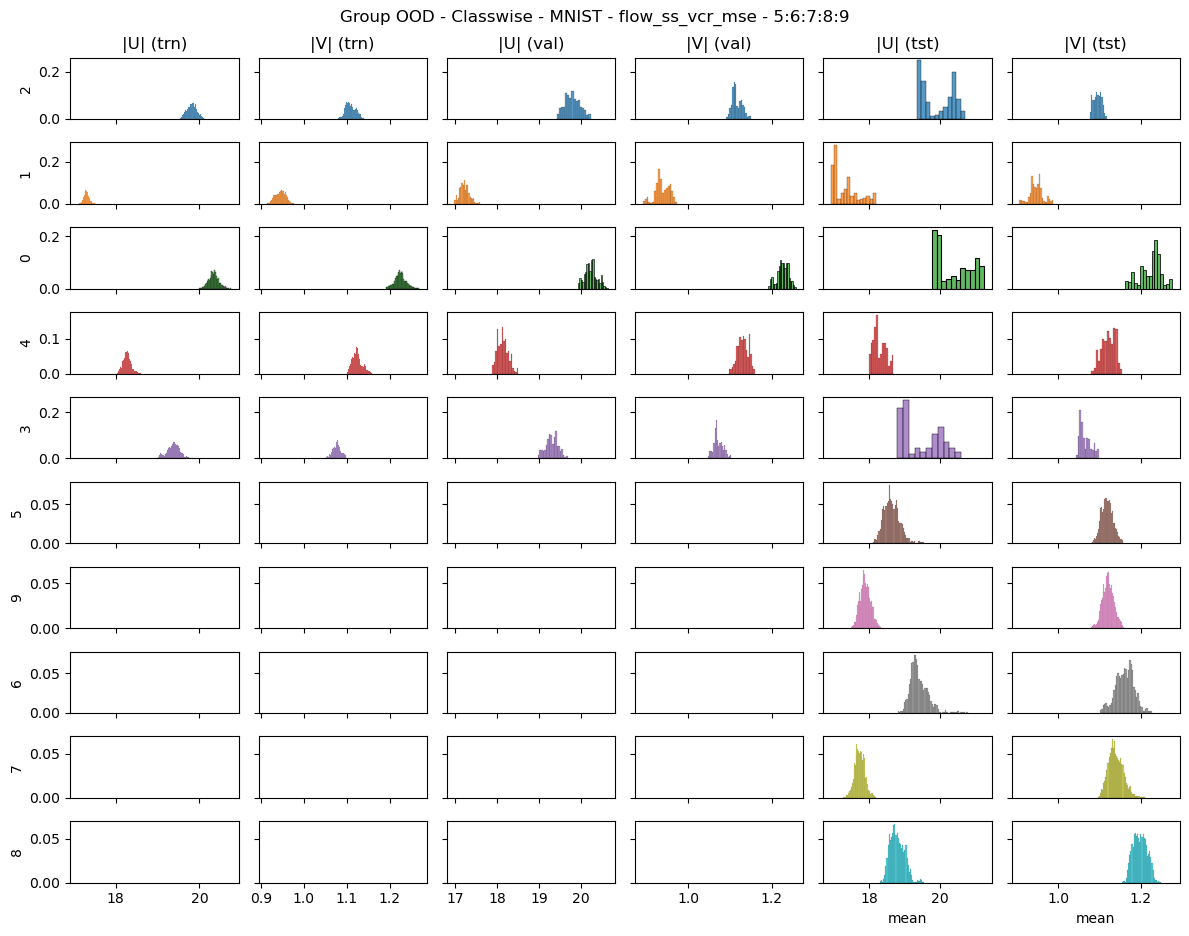

In [20]:
# groupwise
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

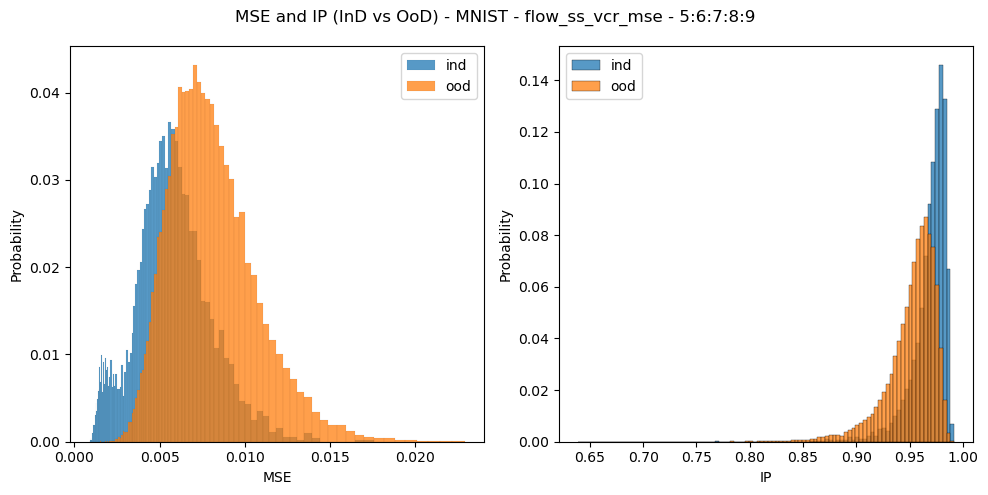

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
_ind_inp_norm = np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7
_ind_rcn_norm = np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7
ind_mse = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_ip = ((_ind_inp/_ind_inp_norm) * (_ind_rcn/_ind_rcn_norm)).sum(-1)
df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ind_tgt, mse=ind_mse, ip=ind_ip, source="ind"))], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    _ood_inp_norm = np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7
    _ood_rcn_norm = np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7
    ood_mse = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_ip = ((_ood_inp/_ood_inp_norm) * (_ood_rcn/_ood_rcn_norm)).sum(-1)
    df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ood_tgt, mse=ood_mse, ip=ood_ip, source="ood"))], ignore_index=True)
    
bins_mse = np.logspace(np.log10(df_rstat['mse'].min() + 1e-7), np.log10(df_rstat['mse'].max()), 100)
bins_ip = np.linspace(df_rstat['ip'].min(), df_rstat['ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="mse", label="ind", stat="probability", bins=bins_mse, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="ip", label="ind", stat="probability", bins=bins_ip, ax=ax2)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="mse", label="ood", stat="probability", bins=bins_mse, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="ip", label="ood", stat="probability", bins=bins_ip, ax=ax2)

ax1.legend()
ax2.legend()
ax1.set_xlabel("MSE")
ax2.set_xlabel("IP")
plt.suptitle(f"MSE and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()